# Module 1: Upper East
## B8474 Real Estate Analytics

# 0: Background and Learning Goals
In this module, we will explore apartment price data for the Upper East Side of Manhattan. The data come from an article I published in the Journal of Urban Economics in May 2022. The article studies the extension of the Second Avenue Q train and how it has impacted house prices. The paper is [online](https://www.sciencedirect.com/science/article/pii/S0094119021001042?dgcid=author) and also uploaded on Canvas as background reading. 

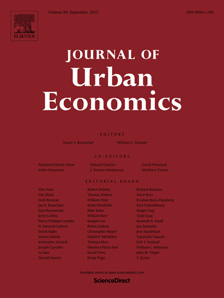

The skills we will develop in this module are:
* inspecting and summarizing a dataset with summary statistics, histograms, kernel density estimation, outliers, and missing observations
* visualizing spatial data on a (heat)map
* merging datasets
* correlations between variables
* regression analysis: coefficient point estimates, standard errors, t-statistics, p-values, and $R^2$
* difference-in-difference estimation of causal estimates of a policy intervention

# 1: Datasets at A Glance
There are two main datasets in this project: a transactions dataset that has each apartment sale and a buildings dataset that has characteristics of the buildings where we have sales transactions during our sample period. We will explore the two datasets and understand the meaning of variables. We'll first examine the univariate distribution, and then turn to correlations between variables. 

In [11]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
from datetime import datetime
print(f"Last runtime: {datetime.now()}")

Last runtime: 2024-01-23 09:07:20.238505


## 1.1 Load Data
Our data are in csv format, which can be directly loaded in Python through pandas. If we know the data type for each column, we can pre-specify them to speed things up, but this is not necessary. Pandas will figure this out automatically (but sometimes gets confused by numeric-like strings, for example).

In [13]:
# load transaction data and building data
transaction = pd.read_csv("../data/transaction_table.csv")
building = pd.read_csv("../data/building_table.csv")

## 1.2 Sample Description
We first want to inspect several observations to get a sense of structure of the dataset and its variables. We can use [`df.head()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) or [`df.tail()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.tail.html) to check the first or last few rows of data.

In [14]:
# check the first 5 rows of the transaction dataframe
# notice that the default number of rows is 5
transaction.head()

,saleprice,address,sqft,date,bathrooms,bedrooms,studio,floor
0,4.253203e+05,105 east 100 street,NaN,2003-02-21,1.0,1.0,0,1
1,4.474949e+05,105 east 100 street,NaN,2017-03-24,1.0,1.0,0,5
2,1.144980e+06,109 east 100th street,2219.0,2009-10-19,3.0,4.0,0,1
3,6.669982e+05,109 east 100th street,979.0,2006-04-05,NaN,1.0,0,2
4,6.118846e+05,109 east 100th street,979.0,2009-07-29,1.0,2.0,0,4


In [15]:
# check the last 3 rows of the building dataframe
building.tail(3)

,address,yearbuilt,numunits,stories,longitude,latitude,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode,group
1134,993 park avenue,1915,49.0,13.0,-73.958076,40.778591,2.012626,0.278375,0.188276,0.188276,10028.0,Lexington Ave
1135,995 fifth avenue,1926,37.0,17.0,-73.962730,40.778091,1.987771,0.083885,0.469136,0.469136,10028.0,Madison Ave
1136,east 97th street,1930,25.0,NaN,-73.949364,40.786083,2.778157,0.377795,0.127381,0.127381,10029.0,Lexington Ave


If the first (or last) several observations are not representative, we can use [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to get a randome sample from the dataframe.

In [16]:
# check a random sample of 3 of the building dataframe
building.sample(3)

,address,yearbuilt,numunits,stories,longitude,latitude,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode,group
226,140 east 81st street,1928,83.0,12.0,-73.957703,40.776070,1.920042,0.405135,0.233636,0.233636,10028.0,Lexington Ave
445,207 east 74th street,1963,120.0,13.0,-73.958794,40.770840,1.695726,0.557371,0.283967,0.195111,10021.0,Second Ave
429,203 east 89th street,1920,20.0,5.0,-73.951973,40.780609,2.440131,0.477214,0.262841,0.262841,10128.0,Second Ave


In addition to inspecting a sample from the dataframe, pandas also have a built-in function to check data type for each columns, [`df.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html), and another function which describes the variables' distribution and several important percentiles, [`df.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html).

In [17]:
# check value types of the transaction dataframe
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44299 entries, 0 to 44298
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   saleprice  44299 non-null  float64
 1   address    44299 non-null  object 
 2   sqft       26691 non-null  float64
 3   date       44299 non-null  object 
 4   bathrooms  43216 non-null  float64
 5   bedrooms   42337 non-null  float64
 6   studio     44299 non-null  int64  
 7   floor      44299 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 2.7+ MB


In [18]:
# check sample statistics of the building dataframe
building.describe()

,yearbuilt,numunits,stories,longitude,latitude,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode
count,1137.00000,1090.000000,1051.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1072.000000
mean,1939.53562,67.276147,13.334919,-73.957316,40.774672,1.984430,0.450935,0.313723,0.236214,10059.468284
std,29.06405,75.497529,8.830041,0.006411,0.006414,0.536629,0.268038,0.177692,0.121641,41.233376
min,1869.00000,1.000000,3.000000,-73.972710,40.760300,0.788522,0.019263,0.006214,0.005592,10021.000000
25%,1920.00000,18.000000,6.000000,-73.961967,40.770081,1.582015,0.237986,0.186412,0.142294,10028.000000
50%,1928.00000,41.000000,13.000000,-73.957367,40.774529,2.012626,0.405135,0.281482,0.224937,10029.000000
75%,1961.00000,88.000000,17.000000,-73.952431,40.779388,2.441374,0.648713,0.410727,0.308822,10075.000000
max,2019.00000,538.000000,57.000000,-73.943108,40.789448,3.223060,1.127170,0.878621,0.624480,10128.000000


In [19]:
# we can also specify the petailed percentile we want
# .T means transpose the dataframe
building.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
yearbuilt,1137.0,1939.535620,29.064050,1869.000000,1900.000000,1910.000000,1920.000000,1928.000000,1961.000000,2003.000000,2015.000000,2019.000000
numunits,1090.0,67.276147,75.497529,1.000000,2.000000,6.000000,18.000000,41.000000,88.000000,218.000000,369.990000,538.000000
stories,1051.0,13.334919,8.830041,3.000000,4.000000,5.000000,6.000000,13.000000,17.000000,32.000000,42.500000,57.000000
longitude,1137.0,-73.957316,0.006411,-73.972710,-73.970169,-73.968120,-73.961967,-73.957367,-73.952431,-73.946864,-73.944739,-73.943108
latitude,1137.0,40.774672,0.006414,40.760300,40.761672,40.764253,40.770081,40.774529,40.779388,40.785746,40.788269,40.789448
grandcentralwalkingdist,1137.0,1.984430,0.536629,0.788522,0.899574,1.053972,1.582015,2.012626,2.441374,2.778530,2.917966,3.223060
centralparkwalkingdist,1137.0,0.450935,0.268038,0.019263,0.037382,0.083512,0.237986,0.405135,0.648713,0.957163,1.056905,1.127170
closest_pre,1137.0,0.313723,0.177692,0.006214,0.031118,0.090099,0.186412,0.281482,0.410727,0.686244,0.809375,0.878621
closest_post,1137.0,0.236214,0.121641,0.005592,0.018691,0.064623,0.142294,0.224937,0.308822,0.461680,0.545342,0.624480
zipcode,1072.0,10059.468284,41.233376,10021.000000,10021.000000,10021.000000,10028.000000,10029.000000,10075.000000,10128.000000,10128.000000,10128.000000


The graph below shows the four UES corridors: Lexington Ave, Madison Ave, Second Ave, and York Ave. Pandas have a function to report number of values each columns have, [`pd.series.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html). 

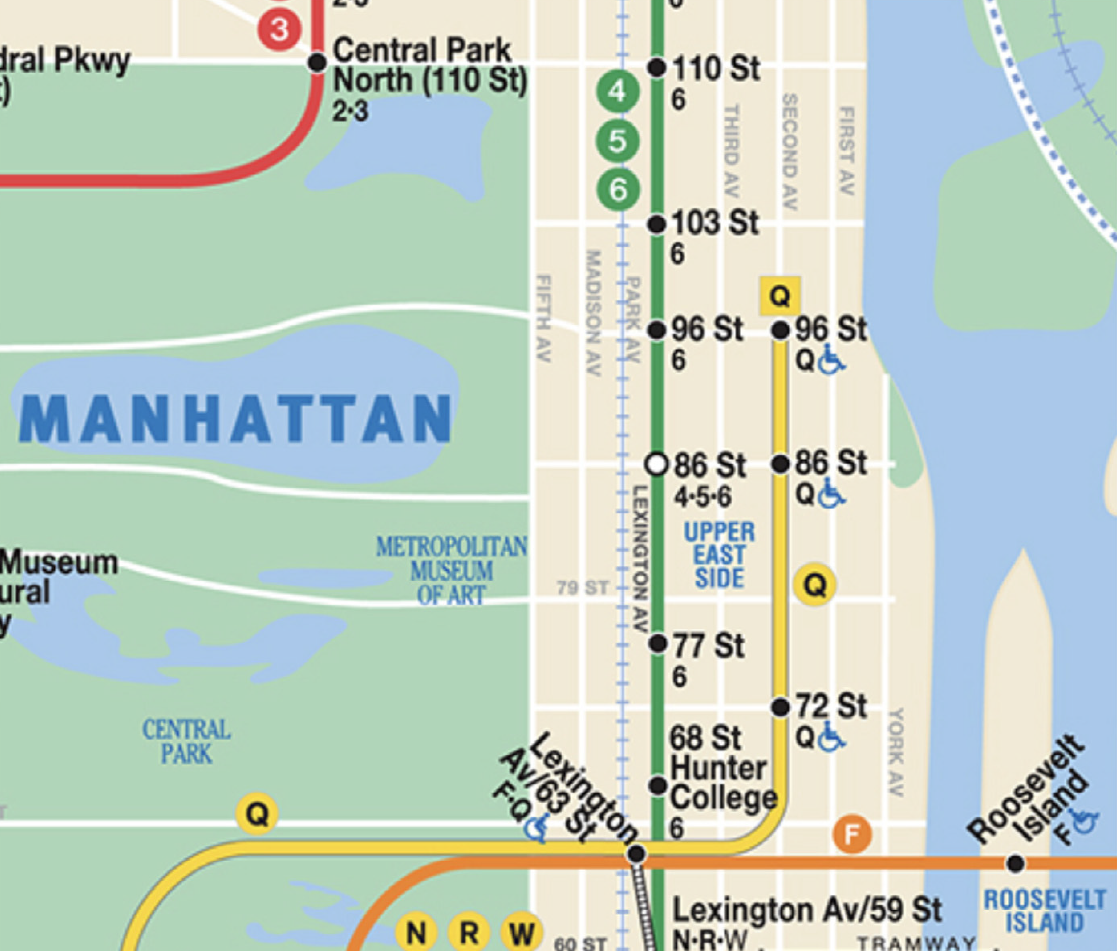

In [20]:
# report the number of buildings in each group (corridor)
building.group.value_counts()

group
Madison Ave      353
Lexington Ave    304
Second Ave       290
York Ave         190
Name: count, dtype: int64

## 1.3 Visualization of Transaction Prices: Time Series
We now plot the statistics of transaction prices to understand the trend over time

In [21]:
# generate month and quarter variables from the date 
# we first convert the date column to datetime type using pd.to_datetime()
# we then turn them into month end date and quarter end date using pd.offsets.MonthEnd() and pd.offsets.QuarterEnd()
# we can now identify the month and quarter of each transaction from the date_monthend and date_quarterend columns
transaction["date_monthend"] = pd.to_datetime(transaction.date) + pd.offsets.MonthEnd(0)
transaction["date_quarterend"] = pd.to_datetime(transaction.date) + pd.offsets.QuarterEnd(0)

In [22]:
# browse the last 5 rows of the transaction dataframe
transaction.tail()

,saleprice,address,sqft,date,bathrooms,bedrooms,studio,floor,date_monthend,date_quarterend
44294,1.299586e+06,1725 york avenue,NaN,2004-09-10,3.0,3.0,0,9,2004-09-30,2004-09-30
44295,2.924670e+06,1725 york avenue,NaN,2007-08-10,3.0,3.0,0,9,2007-08-31,2007-09-30
44296,6.530517e+05,1725 york avenue,NaN,2004-12-14,3.0,3.0,0,9,2004-12-31,2004-12-31
44297,6.045816e+05,1725 york avenue,NaN,2004-03-23,5.0,5.0,0,9,2004-03-31,2004-03-31
44298,1.299586e+06,1725 york avenue,NaN,2004-09-10,NaN,1.0,0,0,2004-09-30,2004-09-30


<Axes: xlabel='date_monthend'>

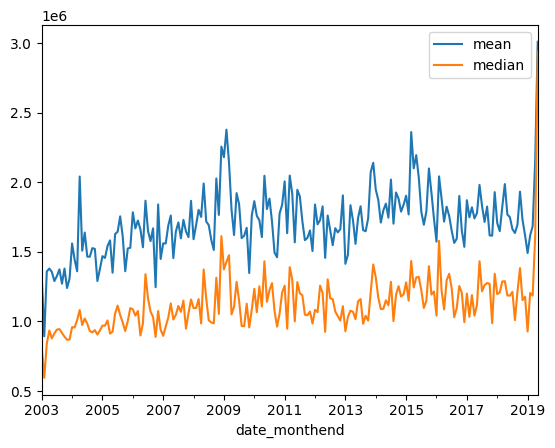

In [23]:
# plot average and median sales price in entire dataset over time, monthly aggregation

# we first group the data by month using .groupby() and then we use .agg() to aggregate the data to get mean and median
# we finally plot the aggregated data, which is also a dataframe, using .plot()
transaction.groupby("date_monthend")["saleprice"].agg(["mean", "median"]).plot()

Notice 2009, prices rose during the crisis. This might be a selection effect. Fewer people were buying, but the ones that were were better off because less well off people weren't buying at all

<Axes: xlabel='date_monthend'>

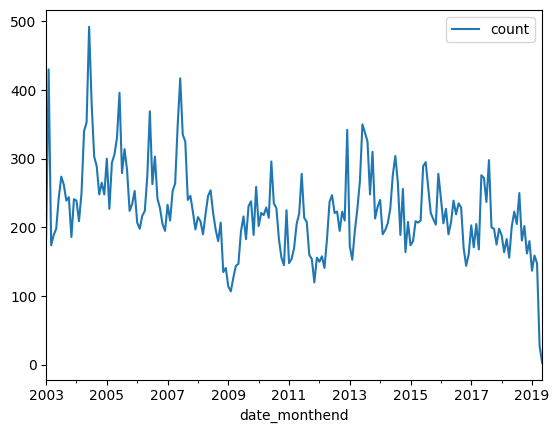

In [24]:
# the first and last month look a bit strange. We hypothesize that this is due to a lack of transactions in those months. 
# Let's plot the number of transactions to investigate this hypothesis
transaction.groupby("date_monthend")["saleprice"].agg(["count"]).plot()

<Axes: xlabel='date_monthend'>

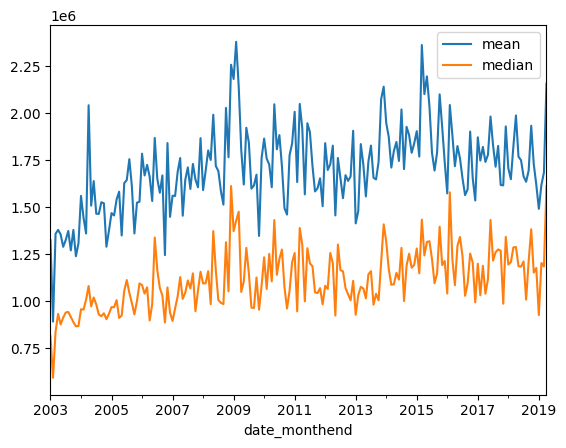

In [25]:
# It seems that there are few transactions in the last month, but plenty in the first month. Therefore, we will exclude the last month from the plot
# we get the timestamp of the last month using .max() and then we exclude the last month 
transaction[transaction["date_monthend"] < transaction["date_monthend"].max()].groupby("date_monthend")["saleprice"].agg(["mean", "median"]).plot() 

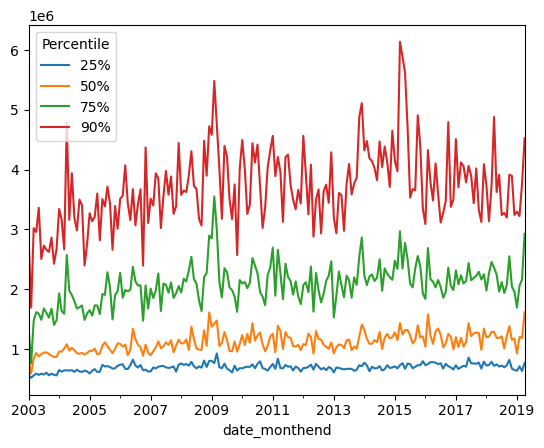

In [26]:
# plot 25, 50, 75, 90th percentiles from the transaction sample

# we drop the last month again
# we group the data by month using .groupby() and then use .quantile() to get the percentiles
# we unstack the four percentile levels into columns using .unstack(), and finally plot the dataframe using .plot()
# we pass the plot object to a variable called ax so that we can modify the legend of the plot
ax = transaction[transaction["date_monthend"] < transaction["date_monthend"].max()].groupby(["date_monthend"])["saleprice"].quantile([0.25, 0.5, 0.75, 0.9]).unstack().plot()
# we modify the legend of the plot using .legend()
ax.legend(["25%", "50%", "75%", "90%"], title = "Percentile")

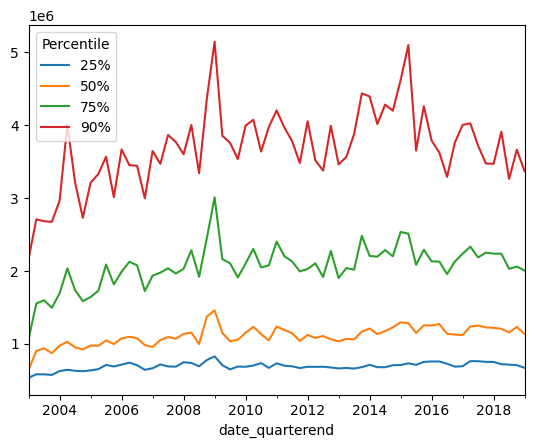

In [27]:
# plot 25, 50, 75, 90th percentiles from the entire sample, quarterly aggregation (drop last quarter)
# aggregating on a lower frequency (quarterly) will give us a smoother plot since there are more transactions in a quarter than in a month to average over

ax = transaction[transaction["date_quarterend"] < transaction["date_quarterend"].max()].groupby(["date_quarterend"])["saleprice"].quantile([0.25, 0.5, 0.75, 0.9]).unstack().plot()
ax.legend(["25%", "50%", "75%", "90%"], title = "Percentile")

## 1.4 Visualization of Discrete Variables: Histogram
The description statistics in section 1.2 may not be adequate to get a good understanding of the distribution of the variables. For discrete variables, we usually use histograms to plot their distributions. The -yaxis could refer to either the frequency (the number of observations) or the density (the fraction of observations). pandas has a built-in method to plot a histogram for a single variable, which is a good start.

In [28]:
# list the variables in our transaction dataframe
transaction.keys()

Index(['saleprice', 'address', 'sqft', 'date', 'bathrooms', 'bedrooms',
       'studio', 'floor', 'date_monthend', 'date_quarterend'],
      dtype='object')

<Axes: ylabel='Frequency'>

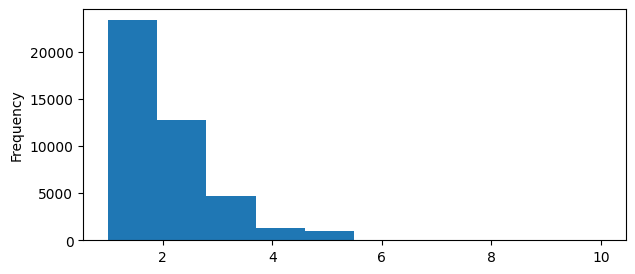

In [29]:
# plot histogram of bathrooms in our transaction dataframe
transaction["bathrooms"].plot.hist(figsize=(7, 3))

In [30]:
# list the variables in our building dataframe
building.keys()

Index(['address', 'yearbuilt', 'numunits', 'stories', 'longitude', 'latitude',
       'grandcentralwalkingdist', 'centralparkwalkingdist', 'closest_pre',
       'closest_post', 'zipcode', 'group'],
      dtype='object')

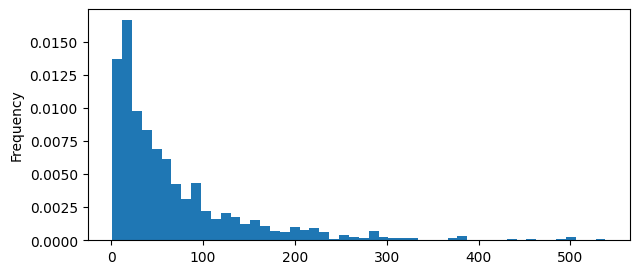

In [31]:
# plot histogram of numunits in our building dataframe
# the plt.show() line get rid of the <AxesSubplot:ylabel='Frequency'> output
building.numunits.plot.hist(bins=50, density=True, figsize=(7, 3))
plt.show()

In addition to plotting the histogram, we can also get the distribution of numunits by counting buildings in discrete bins.

In [32]:
bins = list(np.arange(0, 600, 50))
building["binned"] = pd.cut(building.numunits, bins)
building.groupby(["binned"]).count().numunits

/tmp/ipykernel_482192/2329798540.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  building.groupby(["binned"]).count().numunits


binned
(0, 50]       627
(50, 100]     241
(100, 150]     96
(150, 200]     57
(200, 250]     29
(250, 300]     21
(300, 350]      6
(350, 400]      6
(400, 450]      1
(450, 500]      4
(500, 550]      2
Name: numunits, dtype: int64

In [ ]:
# delete (drop) the column 'binned'
building.drop(columns=["binned"], inplace=True)

#### <span style="color:red">Think-Pair-Share Task 1</span>
Intuitively, the number of units is positively correlated with the number of floors in general. Please generate two histograms of `stories` for `numunits < 100` and `numunits >= 100` respectively. Do your plots support this intuition? Why or why not?

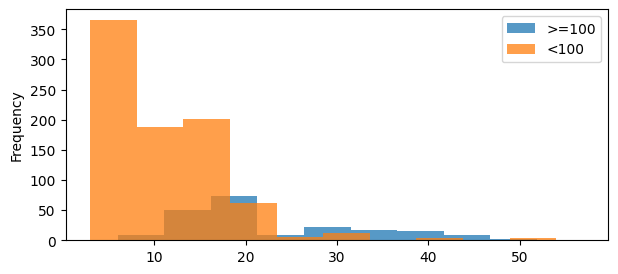

In [45]:
# Enter your code here:

building[building.numunits >= 100].stories.plot.hist(label=">=100",alpha=.75,figsize=(7,3))
building[building.numunits < 100].stories.plot.hist(label="<100",alpha=.75,figsize=(7,3))
plt.legend()
plt.show()


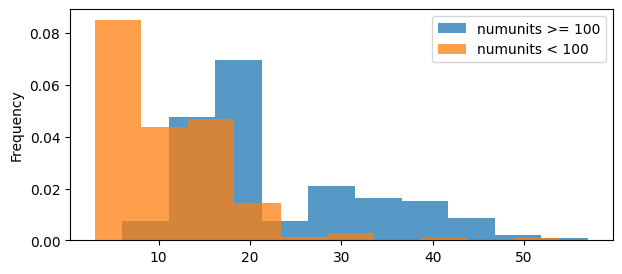

In [46]:
# get stories for building with more than 100 units (inclusive)
more_than_100 = building[building.numunits >= 100].stories

# get stories for building with less than 100 units
less_than_100 = building[building.numunits < 100].stories

# plot histogram
# note: density=True gives probability density; alpha sets the opacity 
more_than_100.plot.hist(density=True, label="numunits >= 100", alpha=0.75, figsize=(7, 3))
less_than_100.plot.hist(density=True, label="numunits < 100", alpha=0.75, figsize=(7, 3))
plt.legend()
plt.show()

## 1.5 Visualization of Continuous Variable: Kernel Density Estimation
For continuous variables, we could still plot histograms, cutting the x-axis into bins and counting the observations in each bin. A different way to visualize he distribution of a continuous variable is as a smooth distribution. Kernel density estimation can help us achieve this goal, using a built-in function in pandas. Kernel density estimation uses a combination of Gaussian (Normally Distributed) kernels to approximate the empirical distribution of the underlying variable.

taking the log means that an increase of 1 increases the underlying value by 100%. 

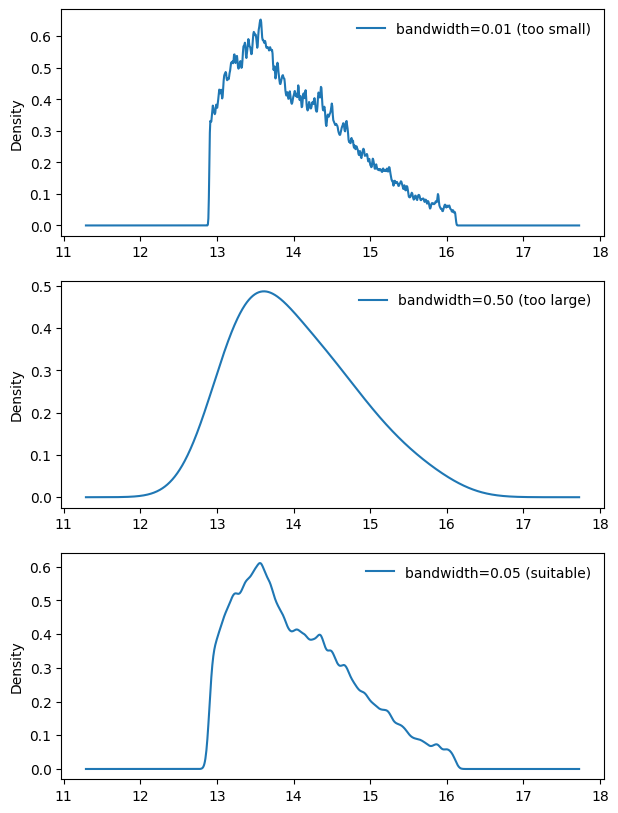

In [49]:
# calculate the natural logarithm of saleprice, call it log_price
transaction["log_price"] = np.log(transaction.saleprice)

# create figure with 3 subplots (3 rows, 1 column)
_, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))

# plot density graph
transaction.log_price.plot.density(bw_method=0.01, ax=axes[0], label="bandwidth=0.01 (too small)")
transaction.log_price.plot.density(bw_method=0.50, ax=axes[1], label="bandwidth=0.50 (too large)")
transaction.log_price.plot.density(bw_method=0.05, ax=axes[2], label="bandwidth=0.05 (suitable)")

# add legend and plot
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
axes[2].legend(frameon=False)
plt.show()

## 1.6 Visualization of Outliers: Box Plot
Outliers may mess up our analysis by making the mean not representative anymore. A commonly used method to detect ourliers is the box plot, where outlieres will be plotted as dot and "normal" values will be inside a box. We will use pandas' built-in function to get a box plot. (See documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html).)

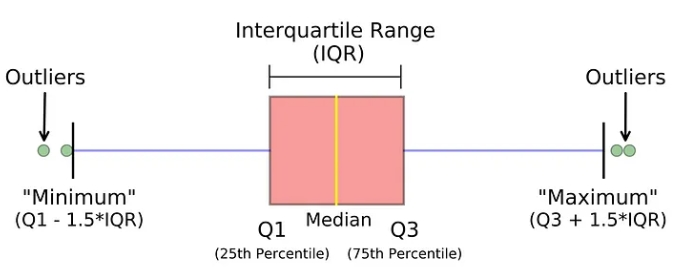

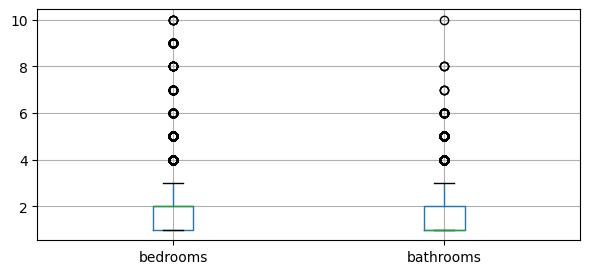

In [47]:
# note the use of double brackets for selecting multiple columns
transaction[["bedrooms", "bathrooms"]].boxplot(figsize=(7, 3))
plt.show()

In [50]:
transaction[["saleprice", "log_price"]].describe()

,saleprice,log_price
count,4.429900e+04,44299.000000
mean,1.688340e+06,14.027014
std,1.600440e+06,0.745909
min,4.000206e+05,12.899271
25%,6.795387e+05,13.429169
50%,1.072022e+06,13.885057
75%,2.032548e+06,14.524801
max,9.997142e+06,16.117810


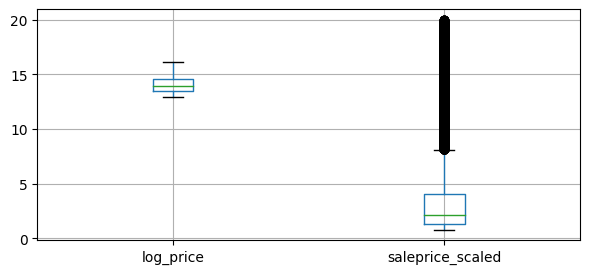

In [ ]:
# because the raw saleprice is too large to compare with log_price, we first
# scale it down. In Python, e5 means 10^5, and 5e5 means 5 * 10^5.
transaction["saleprice_scaled"] = transaction.saleprice / 5e5

# Note that there are almost no outliers for log_price, which is why we did
# this in the first place
transaction[["log_price", "saleprice_scaled"]].boxplot(figsize=(7, 3))
plt.show()

## 1.7 Visualization of Missing Values: `missingno`
Datasets in the real world are often messy, with missing observations. Some variables may have more missing observations than others. Let's see what we have here.

[missingno](https://github.com/ResidentMario/missingno) provides a small toolset of flexible and easy-to-use missing data visualizations and utilities that allows you to get a quick visual summary of the completeness (or lack thereof) of your dataset.

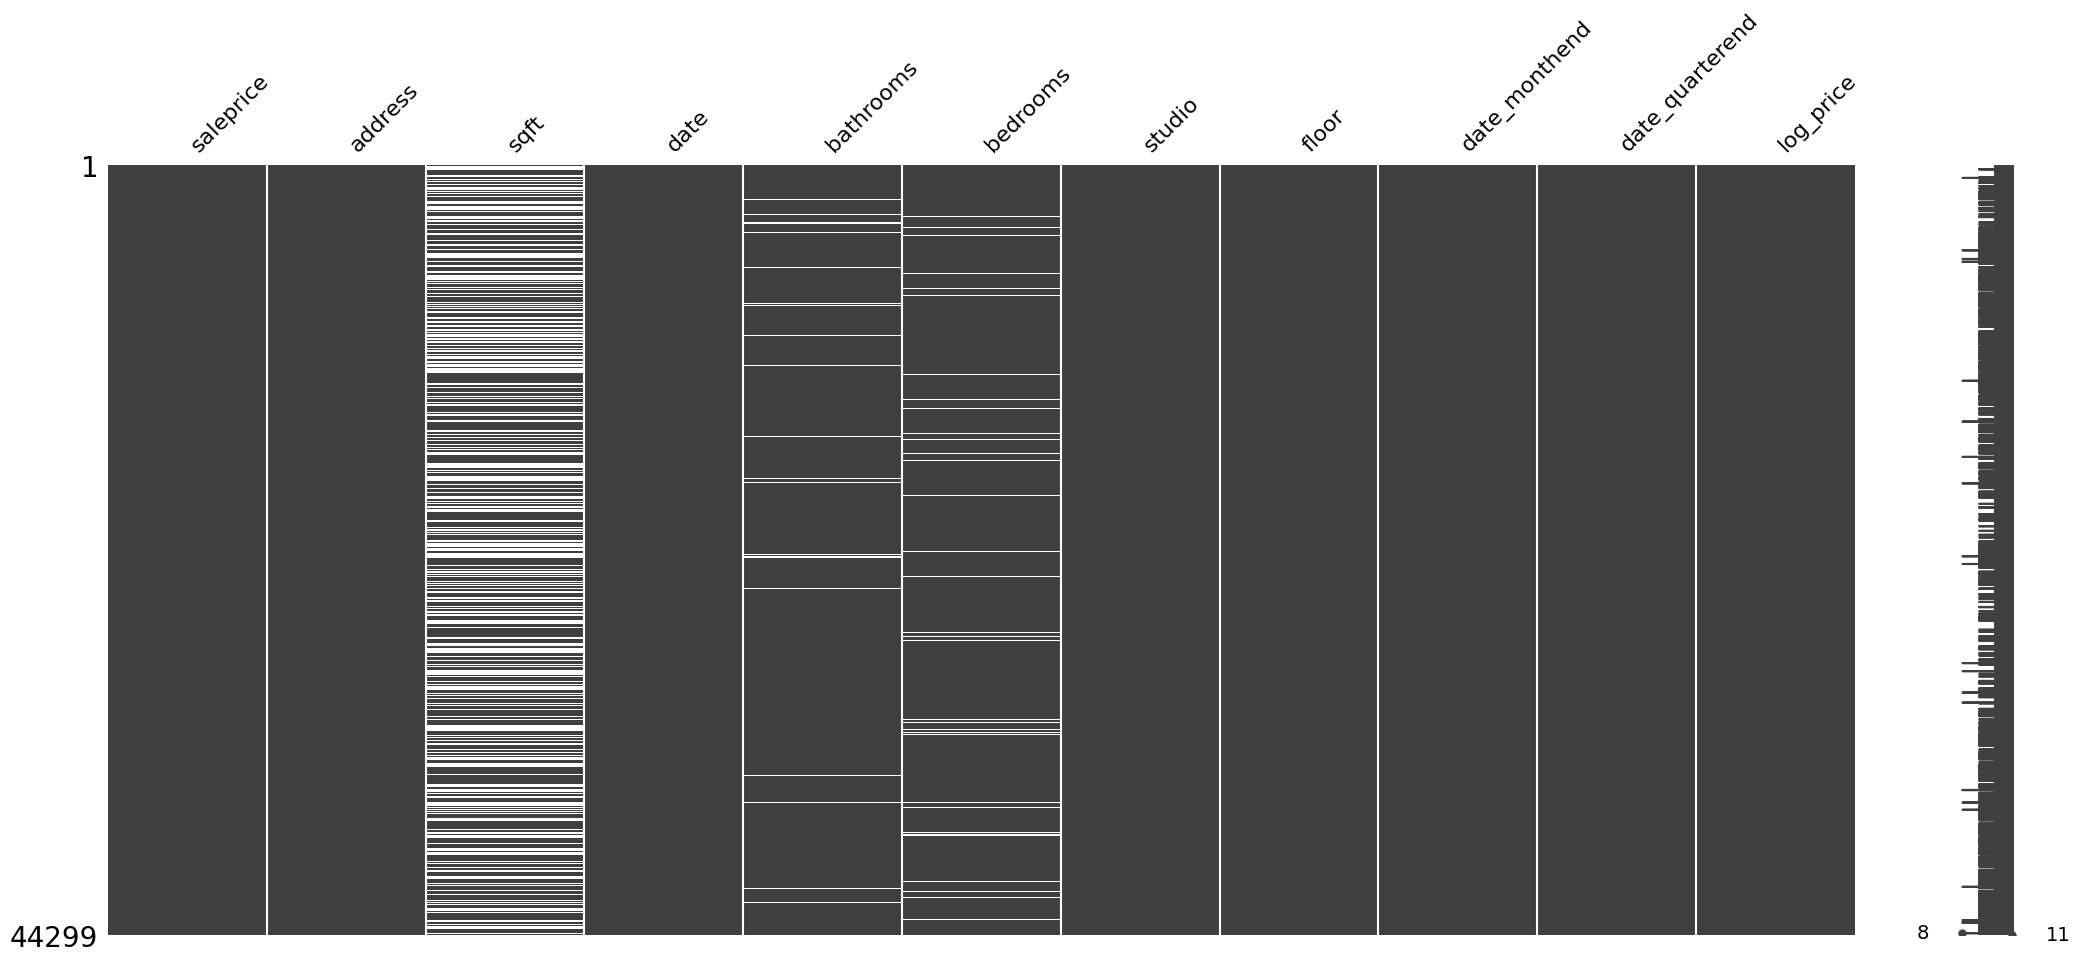

In [51]:
# import package missingno
import missingno as msno

# sort transaction by date and visualize missing values with msno
transaction = transaction.sort_values("date").reset_index(drop=True)
msno.matrix(transaction)
plt.show()

## 1.8 Visualization on a Map

[Folium](http://python-visualization.github.io/folium/) makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map.

In [52]:
# import the mapping package
import folium
from folium import Marker
from folium.plugins import HeatMap

# create map object, specify the center of the map, zoom_start defines the
# boundaries of the map.
# notice that map is a Python keyword, so we add a underscore behind the name
center = [40.7708, -73.9560]
map_ = folium.Map(location=center, tiles="cartodbpositron", zoom_start=14)

# round the latitude and longitude data in our building dataframe
building.latitude = np.round(building.latitude, 3)
building.longitude = np.round(building.longitude, 3)

# define the log of the number of units in each building
building["log_numunits"] = np.log(building.numunits)

# define a new matrix that includes latitude, longitude and the log number of
# units; drop NaN and group observations by (lat, lon), and compute the median
# log_units in each group
medium_log_numunits = building[["latitude", "longitude", "log_numunits"]].dropna() \
                            .groupby(["latitude", "longitude"]) \
                            .median() \
                            .reset_index() \
                            .to_numpy()

# Adding a heatmap to the base map (map_) and display
HeatMap(data=medium_log_numunits, radius=6, blur=1).add_to(map_)

# display the map
map_

In [56]:
station = pd.read_csv("../data/subway_station_geom.csv")
station.head()

,url,objectid,name,the_geom,line,notes
0,http://web.mta.info/nyct/service/,451,86th St,POINT (-73.95558899985132 40.77949199820952),4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre..."
1,http://web.mta.info/nyct/service/,641,72nd St,POINT (-73.95836178682246 40.76880251014895),Q,Q-all times
2,http://web.mta.info/nyct/service/,642,86th St,POINT (-73.95177090964917 40.77786104333163),Q,Q-all times
3,http://web.mta.info/nyct/service/,643,96th St,POINT (-73.9470660219183 40.784236650177654),Q,Q-all times
4,http://web.mta.info/nyct/service/,351,Lexington Ave - 63rd St,POINT (-73.96608964413245 40.76461809442373),F-Q,"F-all times, Q all times"


In [57]:
# read station location data
station = pd.read_csv("../data/subway_station_geom.csv")

# define the latitude and longitude columns adnd split the_geom into two 
# separate variables
station["lat"] = station.the_geom.apply(lambda x: float(x.split("(")[-1].split(" ")[0]))
station["lon"] = station.the_geom.apply(lambda x: float(x.split(")")[0].split(" ")[-1]))

# check 3 samples
station.info()
station.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   url       10 non-null     object 
 1   objectid  10 non-null     int64  
 2   name      10 non-null     object 
 3   the_geom  10 non-null     object 
 4   line      10 non-null     object 
 5   notes     10 non-null     object 
 6   lat       10 non-null     float64
 7   lon       10 non-null     float64
dtypes: float64(2), int64(1), object(5)
memory usage: 768.0+ bytes


,url,objectid,name,the_geom,line,notes,lat,lon
5,http://web.mta.info/nyct/service/,357,Lexington Ave - 59th St,POINT (-73.96737501711436 40.762708855394564),N-R-W,"N-all times, R-all times exc nights, W part time",-73.967375,40.762709
3,http://web.mta.info/nyct/service/,643,96th St,POINT (-73.9470660219183 40.784236650177654),Q,Q-all times,-73.947066,40.784237
4,http://web.mta.info/nyct/service/,351,Lexington Ave - 63rd St,POINT (-73.96608964413245 40.76461809442373),F-Q,"F-all times, Q all times",-73.966090,40.764618


In [58]:
# redefine the map object (thereby deleting the previous one)
map_ = folium.Map(location=center, tiles="cartodbpositron", zoom_start=14)

building_loc = building[["latitude", "longitude"]].drop_duplicates() \
                                                  .dropna() \
                                                  .to_numpy()

# add heatmap of building locations
HeatMap(data=building_loc, radius=5, blur=1).add_to(map_)

# add markers of subway stations
for _, row in station.iterrows():
    loc = [row.lon, row.lat]
    Marker(loc, popup=row.name).add_to(map_)

# display the map
map_

# 2: Data Merging
In this section, we will merge the transactions and buildings dataset together for further analysis.

## 2.1 `pd.merge`
[pd.merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) merge DataFrame or named Series objects with a database-style [join](https://en.wikipedia.org/wiki/Join_(SQL)).

Using `pd.merge` is the most direct way of implementing the data merging, just like the name indicates. (For Stata users: Unlike in Stata, we don't need to explicitly specify whether it's a 1:n, n:1, or n:m mapping. But it's a good habit to check the merging specification using the "validate" option in pd.merge().) We need to choose whether it is a left-join, right-join, inner-join (sometimes called natural-join), or outer-join (sometimes called cartesian). 
* Left-join: we put the variables in the first df first and look for a match with the second df. If there is no match, the variables in the second df are set to na. 
* Right-join: we put the columns of the second df first. 
* Inner-join: starting from the first df, if no merge is found in the second df, we drop the entire observation (not just filled as missing)
* outer-join: we keep all information in the two dfs. If left observation doesn't find a matched right observation, keep the left info and fill right columns as missing. If right observation doesn't find a matched left observation, keep the right info and fill left columns as missing

The column used to merge the two datasets on does not need to have the exact same name in both datasets. If two columns have the same name `'ABC'` but are not the variable on which we merge, the variable names will become `'ABC_x'` and `'ABC_y'`. One should try to avoid this issue by renaming columns in advance.

In [59]:
merged = pd.merge(transaction, building, how="left", on="address")
merged.sample(3)

,saleprice,address,sqft,date,bathrooms,bedrooms,studio,floor,date_monthend,date_quarterend,...,longitude,latitude,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode,group,binned,log_numunits
36449,1876324.232,880 fifth avenue,NaN,2015-12-30,1.0,1.0,0,4,2015-12-31,2015-12-31,...,-73.968,40.771,1.407409,0.020505,0.347969,0.347969,10021.0,Madison Ave,"(150, 200]",5.087596
29022,1599739.723,3 east 77th street,NaN,2013-06-05,1.0,1.0,0,11,2013-06-30,2013-06-30,...,-73.964,40.775,1.755378,0.086992,0.236122,0.236122,10075.0,Madison Ave,"(50, 100]",4.219508
43493,7453899.351,983 park avenue,3300.0,2018-11-01,4.0,3.0,0,6,2018-11-30,2018-12-31,...,-73.958,40.778,1.981558,0.309444,0.219345,0.219345,10028.0,Lexington Ave,"(50, 100]",4.077537


In [60]:
# another way to use the merge function
merged = transaction.merge(building, how="left", on="address")
merged.sample(3)

,saleprice,address,sqft,date,bathrooms,bedrooms,studio,floor,date_monthend,date_quarterend,...,longitude,latitude,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode,group,binned,log_numunits
26236,1680038.083,1235 park avenue,1538.0,2012-05-22,2.0,2.0,0,15,2012-05-31,2012-06-30,...,-73.952,40.786,2.609144,0.232393,0.096934,0.096934,10128.0,Lexington Ave,"(50, 100]",4.094345
6384,2112111.347,201 east 80th street,1704.0,2004-12-17,3.0,3.0,0,5,2004-12-31,2004-12-31,...,-73.956,40.775,1.974722,0.457952,0.263462,0.263462,10028.0,Second Ave,"(50, 100]",4.605170
35048,1353779.621,201 east 66th street,NaN,2015-07-08,2.0,2.0,0,7,2015-07-31,2015-09-30,...,-73.963,40.766,1.254552,0.445524,0.201325,0.201325,10065.0,Second Ave,"(250, 300]",5.545177


## 2.2 `df.update`
[df.update](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.update.html) modify in place using non-NA values from another DataFrame.

Using `pd.merge` is simple but inefficient both in terms of memory and space. It creates copies of each of the datasets and becomes extremely cumbersome when manipulating a large dataset. A more efficient way is to use the `df.update` method to merge. It only creates a copy of one of the datasets and is very fast thanks to a C++ accelerator. However, this method only works when there is a 1:1 or 1:n mapping between the datasets. It also requires that the merging column has exactly the same name in both datasets and is the index in each of the two dataframes. 

In [61]:
updated = transaction.copy()

building.set_index("address", inplace=True)
for col in building.columns:
    updated[col] = np.nan
        
updated.set_index("address", inplace=True)
updated.update(building)
updated.reset_index(drop=False, inplace=True)

# 
building.reset_index(drop=False, inplace=True)

# display the updated (merged) dataframe
updated.sample(3)

,address,saleprice,sqft,date,bathrooms,bedrooms,studio,floor,date_monthend,date_quarterend,...,longitude,latitude,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode,group,binned,log_numunits
8054,415 east 80th street,4.376982e+05,530.0,2005-06-09,1.0,1.0,0,4,2005-06-30,2005-06-30,...,-73.951,40.773,2.265525,0.749376,0.555507,0.357289,10075.0,York Ave,"(50.0, 100.0]",4.369448
25748,44 east 67th street,3.087833e+06,1450.0,2012-03-01,2.0,2.0,0,10,2012-03-31,2012-03-31,...,-73.967,40.768,1.211677,0.169635,0.182684,0.182684,10065.0,Madison Ave,"(0.0, 50.0]",3.828641
16654,27 east 65th street,1.159670e+06,NaN,2008-03-17,1.0,1.0,0,12,2008-03-31,2008-03-31,...,-73.968,40.767,1.109150,0.202568,0.265948,0.265948,10065.0,Madison Ave,"(50.0, 100.0]",4.406719


## 2.3 Plot the time series of the transaction prices by corridor, using merging

<Axes: xlabel='date_quarterend'>

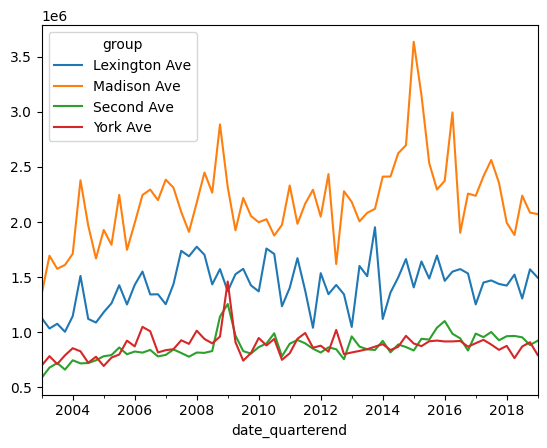

In [ ]:
# plot median sales price by corridor (variable is called "group"), using quarterly aggregation

# we first drop the last quarter, group the data by quarter and group using .groupby(), and then use .median() to get the median sale price
# we then use .unstack() to turn the last level of the index ("group") into columns
# we finally plot the dataframe with four corridor columns using .plot()
merged[merged["date_quarterend"] < merged["date_quarterend"].max()].groupby(["date_quarterend", "group"])["saleprice"].median().unstack().plot()

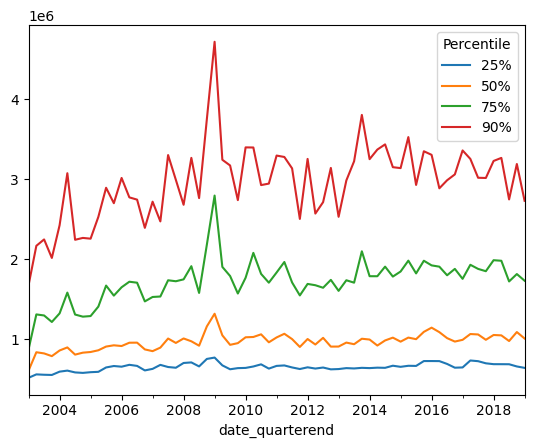

In [62]:
# plot 25, 50, 75, 90th percentiles from the combined sample Lexington, Second, and York, quarterly aggregation

# we first subset the data to only include the three corridors using .isin() and then drop the last quarter
# notice that we need to use "(condition1)&(condition2)" to combine two conditions
# we then group the data by quarter using .groupby() and then use .quantile() to get the percentiles
# we unstack the four percentile levels into columns using .unstack(), and finally plot the dataframe using .plot()
# we pass the plot object to a variable called ax so that we can modify the legend of the plot
ax = merged[(merged.group.isin(["Lexington Ave", "Second Ave", "York Ave"]))&(merged["date_quarterend"] < merged["date_quarterend"].max())].groupby(["date_quarterend"])["saleprice"].quantile([0.25, 0.5, 0.75, 0.9]).unstack().plot()
# we modify the legend of the plot using .legend()
ax.legend(["25%", "50%", "75%", "90%"], title = "Percentile")

## 2.4 Visualize Where Prices Are Highest on a Heatmap
Basically, we want to set weight of the heatmap to be average log prices. Now that we have merged the datasets, we have connected sales prices to buildings. Note that we only kept 3 decimals for longitude and latitude, so if there are multiple observations sharing the same geo location (buildings on a block), we take the mean of their log prices as the weights in the heatmap. This code is very similar to the heatmap code we went through before.

In [65]:
map_ = folium.Map(location=center, tiles="cartodbpositron", zoom_start=14)

mat = merged[["latitude", "longitude", "log_price"]].dropna()
mat = mat.groupby(["latitude", "longitude"]).mean().reset_index().to_numpy()

# add a heat map to the base map
HeatMap(data=mat, radius=5, blur=1).add_to(map_)

# add subway stations to the base map
for _, row in station.iterrows():
    loc = [row.lon, row.lat]
    Marker(loc, popup=row.name).add_to(map_)

# display the map
map_

#### <span style="color:red">Think-Pair-Share Task 2</span>
Now instead of looking at the average price by latitute-longitude, plot the 90th percentile price.

In [66]:
# Enter your code here:
map_ = folium.Map(location=center, tiles="cartodbpositron", zoom_start=14)

mat = merged[["latitude", "longitude", "log_price"]].dropna()
mat = mat.groupby(["latitude", "longitude"]).quantile(.9).reset_index().to_numpy()

# add a heat map to the base map
HeatMap(data=mat, radius=5, blur=1).add_to(map_)

# add subway stations to the base map
for _, row in station.iterrows():
    loc = [row.lon, row.lat]
    Marker(loc, popup=row.name).add_to(map_)

# display the map
map_

In [ ]:
map_ = folium.Map(location=center, tiles="cartodbpositron", zoom_start=14)

mat = merged[["latitude", "longitude", "log_price"]].dropna()
mat = mat.groupby(["latitude", "longitude"]) \
         .apply(lambda x: np.percentile(x, 90)) \
         .reset_index() \
         .to_numpy()

# add heatmap to the base map
HeatMap(data=mat, radius=5, blur=1).add_to(map_)

# add subway stations to the base map
for _, row in station.iterrows():
    loc = [row.lon, row.lat]
    Marker(loc, popup=row.name).add_to(map_)

# display the map
map_

# 3: Examining Dependencies Between Variables in the Dataset
In this section, we will study the joint distribution of variables in the dataset using correlation analysis.

## 3.1 Multi-Variate Visualization: Correlation Matrix
The most direct way of analyzing the dependency of two variables is the correlation. We use [df.corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html), a built-in method in pandas, to calculate pairwise correlations.

In [67]:
merged.select_dtypes(include='number').corr(method="pearson")

,saleprice,sqft,bathrooms,bedrooms,studio,floor,log_price,yearbuilt,numunits,stories,longitude,latitude,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode,log_numunits
saleprice,1.000000,0.007120,0.588115,0.568717,-0.147410,0.065600,0.912260,-0.082361,-0.212898,-0.001733,-0.266912,0.027133,-0.148817,-0.320422,-0.143422,0.011801,-0.023069,-0.247966
sqft,0.007120,1.000000,0.036067,0.026621,-0.021590,-0.065965,0.005710,0.002722,0.032254,0.019465,-0.018039,0.014292,-0.007475,-0.037507,-0.041121,-0.054314,-0.008417,0.034917
bathrooms,0.588115,0.036067,1.000000,0.661263,-0.152962,0.080946,0.629647,0.021588,-0.136113,0.073023,-0.101699,0.033125,-0.043113,-0.140086,-0.049541,0.021701,0.003594,-0.142869
bedrooms,0.568717,0.026621,0.661263,1.000000,NaN,0.014814,0.615727,-0.035749,-0.178784,-0.016298,-0.078078,0.075487,-0.010745,-0.153886,-0.061883,0.008283,-0.004640,-0.197557
studio,-0.147410,-0.021590,-0.152962,NaN,1.000000,-0.027238,-0.236435,0.068756,0.042573,0.007307,0.017155,-0.056934,-0.017819,0.064625,0.018728,-0.006713,-0.035383,0.068528
floor,0.065600,-0.065965,0.080946,0.014814,-0.027238,1.000000,0.110275,0.378440,0.394765,0.609429,0.061732,-0.035001,0.019826,0.104685,0.047847,-0.042378,0.067398,0.409110
log_price,0.912260,0.005710,0.629647,0.615727,-0.236435,0.110275,1.000000,-0.043005,-0.198017,0.056668,-0.294671,0.025174,-0.169020,-0.347949,-0.172986,-0.009490,-0.036136,-0.222659
yearbuilt,-0.082361,0.002722,0.021588,-0.035749,0.068756,0.378440,-0.043005,1.000000,0.362869,0.638897,0.243252,-0.076466,0.117027,0.338772,0.160945,-0.017888,0.000232,0.473986
numunits,-0.212898,0.032254,-0.136113,-0.178784,0.042573,0.394765,-0.198017,0.362869,1.000000,0.544927,0.147086,-0.159902,0.014837,0.313746,0.170173,0.048526,0.079662,0.873788
stories,-0.001733,0.019465,0.073023,-0.016298,0.007307,0.609429,0.056668,0.638897,0.544927,1.000000,0.089745,-0.073886,0.022172,0.172655,0.093763,-0.040124,0.075760,0.605999


## 3.2 Multi-Variate Visualization: Scatter Matrix
A scatter matrix is a graphical representation of correlations in pandas. The off-diagonal elements are two-way scatter plots displaying the association between two variables. The on-diagonal plots are histograms. Here, we use [pd.plotting.scatter_matrix](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html).

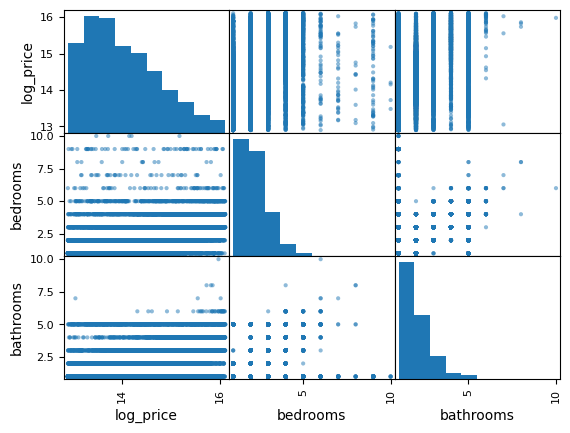

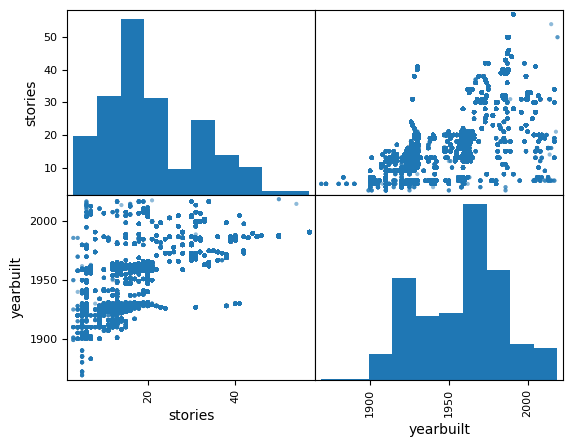

In [68]:
# select three variables and make a 3 x 3 scatter matrix
pd.plotting.scatter_matrix(merged[["log_price", "bedrooms", "bathrooms"]])
plt.show()

# select two variables and make a 2 x 2 scatter matrix
pd.plotting.scatter_matrix(merged[["stories", "yearbuilt"]])
plt.show()

## 3.3 Multi-Variate Visualization: Scatter Plot
When getting an understanding of the relationship between two variables, it is good practise to make a scatter plot. It will show whether there is a weak or strong relationship, and whether that relationship is linear or not. This can inform and help interpret regression analysis down the line. It is not always easy to figure out what the scatter plot implies. For example, in the relationship between sale price and distance from Central Park, there is a negative relationship in the left part of the plot, but once you get more than half a mile away the relationship is not so clear anymore. When you are a mile away, you get closer to the East River, which also has nice views and some high-priced apartments. Later on we'll show a formal regression analysis.

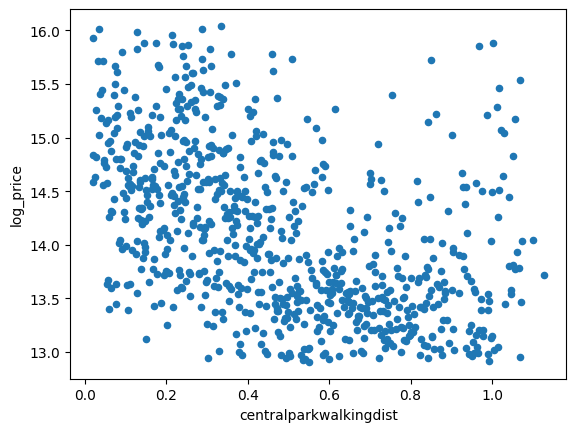

In [69]:
# group by distance and compute the median log price at each distance
# then make scatter plot
median_price = merged.groupby("centralparkwalkingdist").log_price.median()
median_price = median_price.reset_index(drop=False)
median_price.plot.scatter("centralparkwalkingdist", "log_price")
plt.show()

# 4: Regression Analysis
In this section, we will go through basic concepts of OLS and build our OLS function from scratch (also a good recap for statistics 101). We are interested in answering the question **whether the arrival of the Second Avenue Subway extension on the Upper East Side resulted in higher house prices**. To that end, we estimate a regression of log house prices (dependent variable) on the following independent variables: a constant, a dummy that is 1 in the period after subway construction (Post), a dummy that is 1 if the property is located in the Second Ave corridor (On2ndAve), and the interaction (i.e., the product) of these two dummies. It is the interaction effect $\beta_3$ which measures the percentage increase in house prices due to the subway construction. More on this difference-in-difference regression design below. 

$$
    \log(\text{Price}) = \beta_0 + \beta_1\ \text{Post} + \beta_2\ \text{On2ndAve} + \beta_3\ \text{Post} \times \text{On2ndAve} + \varepsilon
$$

## 4.1 Before Regression: Generate Dummies and Intercept
For categorical variables, we need to generate dummies first. There are two ways of doing this: if your data is a dataframe, just like the data here, use the pandas function [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to generate dummy columns in a dataframe structure. If not, you can create your own dummy-generating function.

In [70]:
pd.get_dummies(merged.group, dtype=int).sample(3)

,Lexington Ave,Madison Ave,Second Ave,York Ave
30002,1,0,0,0
6454,0,0,0,1
5739,0,0,1,0


In [72]:
# define the variable On2ndAve which is 1 for a property located on Second Ave
# corridor and 0 otherwise
merged["On2ndAve"] = pd.get_dummies(merged.group, dtype=int)["Second Ave"]

# define an intercept
merged["Intercept"] = 1.0

In [73]:
merged

,saleprice,address,sqft,date,bathrooms,bedrooms,studio,floor,date_monthend,date_quarterend,...,grandcentralwalkingdist,centralparkwalkingdist,closest_pre,closest_post,zipcode,group,binned,log_numunits,On2ndAve,Intercept
0,5.294709e+05,400 east 70th street,620.0,2003-01-01,1.0,1.0,0,15,2003-01-31,2003-03-31,...,1.729280,0.730113,0.479700,0.201325,10021.0,York Ave,"(200.0, 250.0]",5.375278,0,1.0
1,1.629141e+06,250 east 65th street,1750.0,2003-01-01,3.0,3.0,0,12,2003-01-31,2003-03-31,...,1.299912,0.590304,0.299502,0.229287,10065.0,Second Ave,"(50.0, 100.0]",4.477337,1,1.0
2,3.529806e+06,1133 park avenue,NaN,2003-01-02,1.0,2.0,0,3,2003-01-31,2003-03-31,...,2.369294,0.248549,0.315657,0.315657,10128.0,Lexington Ave,"(0.0, 50.0]",3.465736,0,1.0
3,7.263255e+06,181 east 65th street,2807.0,2003-01-02,4.0,4.0,0,24,2003-01-31,2003-03-31,...,1.170045,0.461680,0.170877,0.170877,10065.0,Lexington Ave,"(50.0, 100.0]",4.532599,0,1.0
4,1.900665e+06,60 east end avenue,NaN,2003-01-02,1.0,3.0,0,15,2003-01-31,2003-03-31,...,2.567512,1.050741,0.801571,0.457952,10028.0,York Ave,"(100.0, 150.0]",4.812184,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44294,2.912101e+06,80 east end avenue,NaN,2019-04-29,3.0,4.0,0,15,2019-04-30,2019-06-30,...,2.640834,1.051363,0.780444,0.449252,10028.0,York Ave,"(150.0, 200.0]",5.023881,0,1.0
44295,1.118169e+06,177 east 77th street,1038.0,2019-04-30,1.0,1.0,0,7,2019-04-30,2019-06-30,...,1.763456,0.403892,0.053438,0.053438,10075.0,Lexington Ave,"(50.0, 100.0]",4.043051,0,1.0
44296,5.197901e+06,320 east 82nd street,2708.0,2019-05-01,4.0,4.0,0,4,2019-05-31,2019-06-30,...,2.246263,0.730113,0.480321,0.137323,NaN,Second Ave,NaN,NaN,1,1.0
44297,8.938446e+05,235 east 87th street,NaN,2019-05-01,1.0,2.0,0,6,2019-05-31,2019-06-30,...,2.395392,0.569177,0.219966,0.111226,10128.0,Second Ave,"(100.0, 150.0]",4.934474,1,1.0


#### <span style="color:red">Think-Pair-Share Task 3</span>

Build a dummy variable called `Post` which is 1 for year 2013 onwards, and 0 otherwise. Then display the date and the Post variables, sorting observations by date.

In [ ]:
# Enter your code here:
merged["Post"] = merged[merged.date.year]


In [78]:
merged['year'] =merged.date.str.split("-").str[0].astype(int)

In [85]:
merged["Post"] = (merged.year > 2012).astype(int)

In [86]:
merged.sample(5)

,saleprice,address,sqft,date,bathrooms,bedrooms,studio,floor,date_monthend,date_quarterend,...,closest_pre,closest_post,zipcode,group,binned,log_numunits,On2ndAve,Intercept,year,Post
36327,1.426528e+06,360 east 88th street,984.0,2015-12-15,2.0,1.0,0,20,2015-12-31,2015-12-31,...,0.436204,0.236122,10128.0,Second Ave,"(150, 200]",5.093750,1,1.0,2015,1
12471,1.299615e+06,350 east 82nd street,1037.0,2006-11-03,2.0,2.0,0,5,2006-11-30,2006-12-31,...,0.529410,0.186412,10028.0,Second Ave,"(100, 150]",4.997212,1,1.0,2006,0
25285,5.340460e+05,301 east 64th street,750.0,2011-12-01,1.0,1.0,0,16,2011-12-31,2011-12-31,...,0.289560,0.275268,10065.0,Second Ave,"(100, 150]",4.912655,1,1.0,2011,0
33314,4.588826e+06,120 east 87th street,2100.0,2014-10-28,3.0,3.0,0,17,2014-10-31,2014-12-31,...,0.050331,0.050331,10028.0,Lexington Ave,"(200, 250]",5.389072,0,1.0,2014,1
29181,2.239636e+06,1049 fifth avenue,1120.0,2013-06-19,2.0,2.0,0,6,2013-06-30,2013-06-30,...,0.238607,0.238607,10028.0,Madison Ave,"(50, 100]",4.189655,0,1.0,2013,1


In [ ]:
# define the Post period to be after 2012, when the heavy construction was finished
# we use .apply() to apply a function to each element of the date column
# lambda var: function(var) is a shorthand for defining a function with input named as "var". Here the input is called "dt", you can name it anything you want 
# we use .split() to split the date string (now assigned to variable dt) by "-" and then select the first element, namely the year, by [0] 
merged["Post"] = merged.date.apply(lambda dt: int(dt.split("-")[0]) > 2012)
merged.Post = merged.Post.astype(int)

# display a sample of the values
merged[["date", "Post"]].sort_values("date", ascending=True).sample(5)

,date,Post
21444,2010-04-16,0
43179,2018-09-13,1
28649,2013-04-22,1
25787,2012-03-09,0
8771,2005-08-16,0


## 4.2 Difference-in-differences Estimation

In many situation, we would like to find out what the **causal effect** is of the policy/intervention (here: the construction of the subway extension) on the program outcome (here: the log of house prices).

We could look at the difference between house prices before versus after subway construction. This is the first difference. The problem is that this is not exactly the effect we need because other things may have changed over the period, and that contaminates the program effect we want to estimate. To filter out these contaminants, we want to look at what happened to house prices in a control group (unaffected by the treatment) over that same period. This control group could be Lexington Avenue properties. We then subtract the change in house prices in the "control group" (Lexington Ave) from the change in house prices in the "treatment group" (Second Ave) to get the desired causal effect. This is the second difference (treatment minus control). Volia, the difference-in-difference (DiD) estimate.

We can obtain the DiD estimate and its standard error from a regression. We regress the outcome variable on a Post dummy, a treatment dummy, and the interaction of the treatment and the Post dummy. The coefficient on that interaction term, <span style="color:red">$\beta_3$</span>, is the effect we are interested in. In our case, it tells us how much higher house prices are in the treatment area after subway construction, *relative* to what they would have been in the absence of the subway construction.

$$
    \log(\text{Price}_{it}) = \beta_0 + \beta_1\text{Post}_{it} + \beta_2\text{Treat}_{it} + \color{red}\beta_3\text{Post}_{it}\times\text{Treat}_{it} + \varepsilon_{it}
$$

The coefficient on the treatment effect, $\beta_2$, tells us how much higher house prices are in the treatment area than in the control area during the Pre period. The coefficient on the Post dummy, $\beta_1$, tells us how much higher house prices are in the Post period than in the Pre period in the control area.

Watch this [12-minute](https://www.youtube.com/watch?v=J7q2H8aB8bQ) video to learn about DiD.

To create the interaction effect, we can simply use multiplication. But also keep in mind that we need to adjust for multi-conlinearity, especially for multiple categories. Finally, as a sanity check, we calculate the shape and the rank for the variables by [NumPy](https://numpy.org/).

In [88]:
# construct the interaction effect of post and treatment
merged["On2ndAveXPost"] = merged["On2ndAve"] * merged["Post"]

## 4.3 OLS Regression: 

### Point Estimate of Regression Coefficients

We start with the simplest regression model, the Ordinary Least Squares (OLS) model. Recall the formula for the estimates of the regression coefficients:

$$
    \hat{\beta} = (X'X)^{-1}X'Y
$$

We use [NumPy](https://numpy.org/) to compute the matrix inverse. The best option is [`scipy.linalg.inv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.inv.html), which is faster in scipy objects like sparse matrices.

In [89]:
# construct the matrix of independent variables X, do remember the intercept
independent_vars = ["Intercept", "Post", "On2ndAve", "On2ndAveXPost"]
# we drop rows with missing values in any of the independent variables using .dropna(). Otherwise, the regression will not run
merged = merged.dropna(subset=independent_vars)
# we convert the dataframe to a numpy array using .to_numpy() and then convert the data type to float using .astype(float)
# this is because that the matrix calculation can only be implemented on np arrays with numerical data type
X = merged[independent_vars].to_numpy().astype(float)

# construct the vector of dependent variable Y
Y = merged[["log_price"]].to_numpy().astype(float)

# make sure that their lengths are the same
assert(len(X) == len(Y))

# estimate the regression coefficients, the betas, using the formula above
beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
beta_hat

array([[14.15793136],
       [ 0.05754401],
       [-0.43729747],
       [ 0.11488609]])

In [90]:
# make the result looks prettier by converting it to a dataframe
result = pd.DataFrame(data=beta_hat, index=independent_vars, columns=["beta_hat"])
result

,beta_hat
Intercept,14.157931
Post,0.057544
On2ndAve,-0.437297
On2ndAveXPost,0.114886


Before 2012, prices in the second ave corridor are about 43% lower than in the control group (non-second ave area). The control area price has increased by 5% after 2012. And finally, prices in the treatment area are 11% higher after 2012 than they would have been in the absence of the subway. 

### A Practical Approach

We don't need to code regression on our own, and there are a bunch of useful information other than the coefficients themselves, such as standard errors, p-values, $R^{2}$, etc. In practice, we'll use the package [statsmodels](https://www.statsmodels.org/dev/index.html) to help us estimate regressions.

In [91]:
# import statsmodels package
import statsmodels.api as sm

In [94]:
# prepare regression data by dropping missing values
merged = merged.dropna(subset=["Post", "On2ndAve", "On2ndAveXPost"])
X = merged[["Post", "On2ndAve", "On2ndAveXPost"]].copy()
Y = merged[["log_price"]].copy()

# don't forget the intercept!
# the add_constant() function adds a column of 1s to the left of the dataframe, which will let us estimate the intercept
X = sm.add_constant(X)

# Run the OLS regression 
# Step 1: specify a regression model using the sm.OLS(). This will return a model object
model = sm.OLS(Y, X)
# Step 2: fit the model using .fit(). This will return a result object
result_1 = model.fit()

# print result by calling the method .summary() of the result object
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1128.
Date:                Tue, 23 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:46:31   Log-Likelihood:                -48241.
No. Observations:               44299   AIC:                         9.649e+04
Df Residuals:                   44295   BIC:                         9.652e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.1579      0.005   2602.120

R2 = how much of the variation can be explained. 7.1%
this also shows the 95% confidence interval. So we are 95% confident that the affect of the subway on the treatment group was between 8.6% and 14.3%. 5% chance that it is outside of these values      

## 4.4 Back to the Substance: Subway Anticipation Effects

Because the subway was a long time in the making, real estate investors may have bought apartments in anticipation of future subway opening. Some of the house price effects may already show up earlier, during the "Pre" period. Call them *anticipation* effects. The way we get at that is by splitting the Pre period into 2003-2006 (before the construction even started) and the construction period 2007-2011. We can then estimate the following regression:

$$
    \log(\text{Price}) = \beta_0 + \beta_1\text{Post} + \beta_2\text{ConstrPeriod} + \beta_3\text{On2ndAve} + \beta_4\text{Post}\times\text{On2ndAve} + \beta_5\text{ConstrPeriod}\times\text{On2ndAve} + \varepsilon
$$

The omitted period (base period) is the period 2003-2006. All regression cofficients must now be interpreted relative to this base period.

*Note: It's a good practice to write codes you are going to reuse into function*

In [95]:
# import a package to give type hint
# note: Though not necessary, type hint when you define a function gives more clearity to your code and improve the readability. 
from typing import List, TypeVar
smRegResult = sm.regression.linear_model.RegressionResultsWrapper

In [96]:
def run_ols_regression(
        df: pd.DataFrame, y: str, x: List, 
        intercept: bool = True, verbose: bool = True) -> smRegResult:
    """ Run statsmodels OLS regression
    
    Params:
        df (pd.DataFrame): Data used in regression.
        y (str): Label of the dependent variable.
        x (List): List of labels of independent variable.
        intercept (bool): Whether to add intercept to the model. Default to True.
        verbose (bool): Whether to print regression summary result. Default to True.
        
    Return:
        RegResult: statsmodels regression result object
    """
    # error handling. The code will stop running if x is not a list
    assert(type(x) == list)
    
    # prep data
    df = df.dropna(subset=x + [y])
    
    # get regression data
    X, Y = df[x].copy(), df[[y]].copy()
    
    # add intercept (constant) if the "intercept" input is specified as True
    if intercept:
        X = sm.add_constant(X)

    # run OLS regression
    model = sm.OLS(Y, X)
    result = model.fit()
    
    # print result if the "verbose" input is specified as True
    if verbose:
        print(result.summary())
    
    # return regression result
    return result

In [98]:
# construct regression data
merged["ConstPeriod"] = merged.date.apply(
    lambda dt: 2007 <= int(dt.split("-")[0]) <= 2012).astype(int)
merged["On2ndAveXConstPeriod"] = merged.On2ndAve * merged.ConstPeriod

# run regression
independent_vars = [
    "Post", "ConstPeriod", "On2ndAve", "On2ndAveXConstPeriod", "On2ndAveXPost"
]
result_2 = run_ols_regression(df=merged, y="log_price", x=independent_vars,
                              intercept=True, verbose=True)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     726.3
Date:                Tue, 23 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:58:49   Log-Likelihood:                -48125.
No. Observations:               44299   AIC:                         9.626e+04
Df Residuals:                   44293   BIC:                         9.631e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.0989 

Now, the pre period is smaller, so the Post variable is higher because it encompasses more time where prices were rising. So now the benefit from the subway is 14.2% compared to 11%. This means that the increase is larger when we consider the anticipation effects when construction started. Another way is first 5% increase with construction, and then a further 9% increase after 2012. 

## 4.5 Alternative Treatment Definition: Nearest Subway Station Becomes Closer

Instead of defining a treated property as one that is located on the Second Ave corridor, we can define a treated property as one whose distance to the nearest subway station has become closer after completion of the subway extension. Let the dummy Closer be 1 if after the subway extension, the property is closer, and zero if not. 

We also want to allow for control variables, such as the number of bathrooms and bedrooms and the number of floors in the building.

$$
    \log(\text{Price}) = \beta_0 + \beta_1\text{Post} + \beta_2\text{Closer} + \beta_3\text{Post}\times\text{Closer} + \beta_4\text{Bathrooms} + \beta_5\text{Bedrooms} + \beta_6\text{Floor} + \varepsilon
$$


In [ ]:
# create dummy variable for whether the nearest subway station become closer
merged["ChgClosest"] = merged.closest_pre - merged.closest_post
merged["Closer"] = 0
merged.loc[merged.ChgClosest > 0, "Closer"] = 1

# interaction between Post and Closer
merged["PostXCloser"] = merged.Post * merged.Closer

# run regression using the function we defined above
independent_vars = ["Post", "Closer", "PostXCloser", "bedrooms", "bathrooms", "floor"]
result_3 = run_ols_regression(df=merged, y="log_price", x=independent_vars,
                              intercept=True, verbose=True)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     7696.
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:54:28   Log-Likelihood:                -30352.
No. Observations:               41281   AIC:                         6.072e+04
Df Residuals:                   41274   BIC:                         6.078e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.1308      0.007   1760.600      

#### <span style="color:red">Think-Pair-Share Task 4</span>

Visualize the above regression result by scatter plot. The x-axis is the number of bathrooms, and the y-axis is the predicted log-prices.

In [ ]:
# Enter your code here:


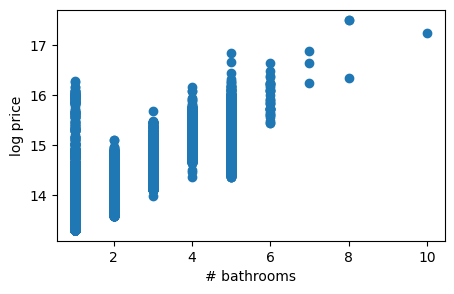

In [ ]:
# res.params gives all the betas from the regression
beta_hat = result_3.params.to_numpy().reshape(-1, 1)

# calculate predicted values
# note that the order of independent variables in X matters
merged["const"] = 1.0
X = merged[["const"] + independent_vars].to_numpy().astype(float)
predicted = X.dot(beta_hat)

# the fifth column in the X matrix is bathrooms
bedrooms = X[:, 5]

# plot scatter plot
# we first create a figure object and an axes object using plt.subplots(). The figure is named as _ (as we don't need it), and the axes is named as ax
_, ax = plt.subplots(figsize=(5, 3))
ax.scatter(bedrooms, predicted)
plt.xlabel("# bathrooms")
plt.ylabel("log price")
plt.show()